# Table of Contents

### 1. Business Problem
### 2. Key Performance Indicator
### 3. Metrics
### 4. Data Wrangling and Cleaning
### 5. Visualizations

## Buiness Problem

Microsoft is looking to break into the movie industry and develop their own studio. However, they do not know anything about making movies. We have been tasked with challenge of developing three data backed actionable insights to present to thhe head of the newly formed movie studio.

## Key Performance Indicator

For the Key Performance Indicator we have decided to work with profit margin, more specifically, average profit margin. Why use profit margin? As Investopedia states, "Profit margins are used by creditors, investors, and businesses themselves as indicators of a company's financial health, management's skill, and growth potential." We feel these are good indicators to use as Microsoft enters the movie market.

## Data Wrangling and Cleaning

In [4]:
#imports necessary packages
import pandas as pd
import numpy as np
import requests
import re
import bleach
from time import sleep
from random import randint
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

In [5]:
# pulls in data sets
movie_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz',delimiter=",")
df_name_basics = pd.read_csv('zippedData/imdb.name.basics.csv.gz',delimiter=',')
imdb_title_akas_df = pd.read_csv('zippedData/imdb.title.akas.csv.gz')
imdb_title_basics_df = pd.read_csv('zippedData/imdb.title.basics.csv.gz')
imdb_title_crew_df = pd.read_csv('zippedData/imdb.title.crew.csv.gz')
imdb_title_principals_df = pd.read_csv('zippedData/imdb.title.principals.csv.gz')
imdb_title_rating_df = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
rt_movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz',delimiter='\t')
rt_reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter='\t',encoding = 'unicode_escape')
tn_movie_budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

Here we use web scraping to pull titles, the tconstant for the movies, the MPAA ratings and the movie Genres. This will help us merge the tables into one table for analyzing later in the project. Additionally, this will help us retain as many data points as possible. We used this website for guidance in building this scrapper: https://betterprogramming.pub/how-to-scrape-multiple-pages-of-a-website-using-a-python-web-scraper-4e2c641cff8

In [6]:
names = []
tconst = []
ratings = []
genres = []
# 11257 is the number of records plus 1 we will iterate through.
# The loop will reset at 50 because there are 50 records on each page. 
for i in range(1, 11257, 50): 
    url = 'https://www.imdb.com/search/title/?title_type=feature&num_votes=5000,&languages=en&sort=boxoffice_gross_us,desc&start={}&ref_=adv_prv'.format(i)
    response = requests.get(url)
    sleep(randint(1,4)) #pauses at a random interval to avoid 
                        #crushing the API and locking out the ISP.
    html_soup = BeautifulSoup(response.text, 'html.parser')
    movie_containers = html_soup.find_all('div', class_='lister-item mode-advanced')
# Extract data from individual movie container
    for container in movie_containers:
# If the movie has Rating, then extract:
        if container.find('span', class_ = 'certificate') is not None:
#name
            name = container.h3.a.text
            names.append(name)
#tconst
            tconsts = container.h3.a['href'][7:16]
            tconst.append(tconsts)
#Rating
            rating = container.find('span', class_ = 'certificate').text
            ratings.append(rating)
#Movie Genres
            genre = container.find('span', class_ = 'genre').text
            genres.append(genre)

In [7]:
#uses the lists from above to create a new data set datframe
IMDB_df = pd.DataFrame({"Movie": names,
                        "tconst" : tconst,
                        "Rating" : ratings,
                        "Genres" : genres})

In [8]:
#cleaning the Movies column to maximize teh number of records that will be output
IMDB_df["Movie"] = IMDB_df["Movie"].str.replace(":", "").str.replace("!", "").str.replace("-", "").str.strip()
#removes any additional charactes from the Genre Column
IMDB_df["Genres"] = IMDB_df["Genres"].map(lambda x: x.strip())

In [9]:
#drops duplicates
IMDB_df = IMDB_df.drop_duplicates("Movie")

In [10]:
#splits the Genre
IMDB_df[["Genre", "Second"]] = IMDB_df["Genres"].str.split(",", n=1, expand=True)

In [11]:
#resulting dataframe
IMDB_df.drop(["Genres","Second"], axis = 1)

,Movie,tconst,Rating,Genre
0,Star Wars Episode VII The Force Awakens,tt2488496,PG-13,Action
1,Avengers Endgame,tt4154796,PG-13,Action
2,Avatar,tt0499549,PG-13,Action
3,Black Panther,tt1825683,PG-13,Action
4,Avengers Infinity War,tt4154756,PG-13,Action
...,...,...,...,...
9794,Far Cry,tt0400426,R,Action
9795,Godzilla Final Wars,tt0399102,PG-13,Action
9796,The Secret of Moonacre,tt0396707,PG,Adventure
9797,House of 9,tt0395585,R,Drama


In [12]:
#budgets data set
tn_movie_budgets_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [13]:
#strips $ and ,s to change to change to float for computation
tn_movie_budgets_df["production_budget"] = tn_movie_budgets_df["production_budget"]\
                                        .str.replace("$", "",regex=True).str.replace(",", "",regex=True)
tn_movie_budgets_df["domestic_gross"] = tn_movie_budgets_df["domestic_gross"]\
                                        .str.replace("$", "",regex=True).str.replace(",", "",regex=True)
tn_movie_budgets_df["worldwide_gross"] = tn_movie_budgets_df["worldwide_gross"]\
                                        .str.replace("$", "",regex=True).str.replace(",", "",regex=True)

In [14]:
#Changes type to float
tn_movie_budgets_df["domestic_gross"] = tn_movie_budgets_df["domestic_gross"].astype(float)
tn_movie_budgets_df["production_budget"] = tn_movie_budgets_df["production_budget"].astype(float)
tn_movie_budgets_df["worldwide_gross"] = tn_movie_budgets_df["worldwide_gross"].astype(float)

In [15]:
#computes Profit Margin
tn_movie_budgets_df["profit_margin"] = ((tn_movie_budgets_df["worldwide_gross"] - tn_movie_budgets_df["production_budget"]) 
                                        / tn_movie_budgets_df["worldwide_gross"])

In [16]:
#cleaning the Movie titles from "The Numbers" dataframe for merging
tn_movie_budgets_df["movie"] = tn_movie_budgets_df["movie"].str.replace(":", "").str.replace("!", "").str.replace("-", "")
#strips month from release date to analyze later
tn_movie_budgets_df["release_date"] = tn_movie_budgets_df["release_date"].map(lambda x:x[:3])

In [17]:
#resulting dataframe
tn_movie_budgets_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit_margin
0,1,Dec,Avatar,425000000.0,760507625.0,2.776345e+09,0.846921
1,2,May,Pirates of the Caribbean On Stranger Tides,410600000.0,241063875.0,1.045664e+09,0.607331
2,3,Jun,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-1.337036
3,4,May,Avengers Age of Ultron,330600000.0,459005868.0,1.403014e+09,0.764364
4,5,Dec,Star Wars Ep. VIII The Last Jedi,317000000.0,620181382.0,1.316722e+09,0.759251
...,...,...,...,...,...,...,...
5777,78,Dec,Red 11,7000.0,0.0,0.000000e+00,-inf
5778,79,Apr,Following,6000.0,48482.0,2.404950e+05,0.975051
5779,80,Jul,Return to the Land of Wonders,5000.0,1338.0,1.338000e+03,-2.736921
5780,81,Sep,A Plague So Pleasant,1400.0,0.0,0.000000e+00,-inf


In [18]:
#Merges Dataframe
merged_df = pd.merge(left=IMDB_df, right=tn_movie_budgets_df, how="inner", left_on = "Movie", right_on= "movie")

In [19]:
#resluting DataFrame
merged_df

,Movie,tconst,Rating,Genres,Genre,Second,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit_margin
0,Avatar,tt0499549,PG-13,"Action, Adventure, Fantasy",Action,"Adventure, Fantasy",1,Dec,Avatar,425000000.0,760507625.0,2.776345e+09,0.846921
1,Black Panther,tt1825683,PG-13,"Action, Adventure, Sci-Fi",Action,"Adventure, Sci-Fi",42,Feb,Black Panther,200000000.0,700059566.0,1.348258e+09,0.851660
2,Avengers Infinity War,tt4154756,PG-13,"Action, Adventure, Sci-Fi",Action,"Adventure, Sci-Fi",7,Apr,Avengers Infinity War,300000000.0,678815482.0,2.048134e+09,0.853525
3,Titanic,tt0120338,PG-13,"Drama, Romance",Drama,Romance,43,Dec,Titanic,200000000.0,659363944.0,2.208208e+09,0.909429
4,Jurassic World,tt0369610,PG-13,"Action, Adventure, Sci-Fi",Action,"Adventure, Sci-Fi",34,Jun,Jurassic World,215000000.0,652270625.0,1.648855e+09,0.869606
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4171,Goodbye Bafana,tt0438859,R,"Biography, Drama, History",Biography,"Drama, History",10,Dec,Goodbye Bafana,30000000.0,0.0,2.717302e+06,-10.040363
4172,Virgin Territory,tt0437954,R,"Adventure, Comedy, History",Adventure,"Comedy, History",84,Aug,Virgin Territory,38000000.0,0.0,5.473041e+06,-5.943124
4173,Krrish,tt0432637,Not Rated,"Action, Adventure, Sci-Fi",Action,"Adventure, Sci-Fi",89,Jun,Krrish,10000000.0,1430721.0,3.243072e+07,0.691650
4174,Bandidas,tt0416496,PG-13,"Action, Comedy, Crime",Action,"Comedy, Crime",55,Sep,Bandidas,35000000.0,0.0,1.928259e+07,-0.815109


In [20]:
#drops unnecessary columns
merged_df = merged_df[["movie",
                       "Rating",
                       "release_date",
                       "Genre",
                       "production_budget",
                       "domestic_gross", 
                       "worldwide_gross",
                       "profit_margin"]]
merged_df

,movie,Rating,release_date,Genre,production_budget,domestic_gross,worldwide_gross,profit_margin
0,Avatar,PG-13,Dec,Action,425000000.0,760507625.0,2.776345e+09,0.846921
1,Black Panther,PG-13,Feb,Action,200000000.0,700059566.0,1.348258e+09,0.851660
2,Avengers Infinity War,PG-13,Apr,Action,300000000.0,678815482.0,2.048134e+09,0.853525
3,Titanic,PG-13,Dec,Drama,200000000.0,659363944.0,2.208208e+09,0.909429
4,Jurassic World,PG-13,Jun,Action,215000000.0,652270625.0,1.648855e+09,0.869606
...,...,...,...,...,...,...,...,...
4171,Goodbye Bafana,R,Dec,Biography,30000000.0,0.0,2.717302e+06,-10.040363
4172,Virgin Territory,R,Aug,Adventure,38000000.0,0.0,5.473041e+06,-5.943124
4173,Krrish,Not Rated,Jun,Action,10000000.0,1430721.0,3.243072e+07,0.691650
4174,Bandidas,PG-13,Sep,Action,35000000.0,0.0,1.928259e+07,-0.815109


In [21]:
#renames coloumns for consistancy
merged_df = merged_df.rename(columns = {"Rating":"rating",
                                        "Genre": "genre",
                                       "release_date":"release_month"})

Negative values need to be removed from the data set because further calculations will return false infinity values during data analyzation.

In [22]:
#removes negative profit margins for calulations
merged_df = merged_df[merged_df["profit_margin"] > 0]
merged_df = merged_df.sort_values("profit_margin", ascending=False)

In [23]:
#removes duplicate movies
merged_df = merged_df.drop_duplicates("movie")
merged_df

,movie,rating,release_month,genre,production_budget,domestic_gross,worldwide_gross,profit_margin
3104,Mad Max,R,Mar,Action,200000.0,8750000.0,99750000.0,0.997995
569,Paranormal Activity,R,Sep,Horror,450000.0,107918810.0,194183034.0,0.997683
2339,The Gallows,R,Jul,Horror,100000.0,22764410.0,41656474.0,0.997599
374,The Blair Witch Project,R,Jul,Horror,600000.0,140539099.0,248300000.0,0.997584
606,Bambi,G,Aug,Animation,858000.0,102797000.0,268000000.0,0.996799
...,...,...,...,...,...,...,...,...
3665,Stoker,R,Mar,Drama,12000000.0,1703125.0,12034913.0,0.002901
1397,Absolute Power,R,Feb,Action,50000000.0,50068310.0,50068310.0,0.001364
1521,The Replacements,PG-13,Aug,Comedy,50000000.0,44737059.0,50054511.0,0.001089
3633,Nemesis,R,Jan,Action,2000000.0,2001124.0,2001124.0,0.000562


Only interested in G, PG, PG-13 and R ratings. The ratings below had such small ocurances the calcualtions revealed anomalies. We determined losing the 75 movies was better for the analyzing.

In [24]:
merged_df = merged_df[merged_df.rating != "Not Rated"]

In [25]:
merged_df = merged_df[merged_df.rating != "Approved"]

In [26]:
merged_df = merged_df[merged_df.rating != "Passed"]

In [27]:
merged_df = merged_df[merged_df.rating != "Unrated"]

In [28]:
merged_df =  merged_df[merged_df.rating != "NC-17"]

In [29]:
merged_df = merged_df[merged_df.rating != "TV-MA"]

In [30]:
merged_df = merged_df[merged_df.rating != "GP"]

In [31]:
merged_df = merged_df[merged_df.rating != "TV-14"]

In [32]:
merged_df = merged_df[merged_df.rating != "M"]

In [33]:
merged_df = merged_df[merged_df.rating != "M/PG"]

These genres had the same issues as the ratings we removed. Again, we determined it was better for analyzing to remove these from the data base.

In [34]:
merged_df = merged_df[merged_df.genre != "Fantasy"]

In [35]:
merged_df = merged_df[merged_df.genre != "Mystery"]

In [36]:
merged_df = merged_df[merged_df.genre != "Thriller"]

In [37]:
merged_df = merged_df[merged_df.genre != "Family"]

In [38]:
merged_df = merged_df[merged_df.genre != "Western"]

In [39]:
merged_df = merged_df[merged_df.genre != "Sci-Fi"]

In [40]:
merged_df = merged_df[merged_df.genre != "Romance"]

In [41]:
merged_df = merged_df[merged_df.genre != "Musical"]
merged_df

,movie,rating,release_month,genre,production_budget,domestic_gross,worldwide_gross,profit_margin
3104,Mad Max,R,Mar,Action,200000.0,8750000.0,99750000.0,0.997995
569,Paranormal Activity,R,Sep,Horror,450000.0,107918810.0,194183034.0,0.997683
2339,The Gallows,R,Jul,Horror,100000.0,22764410.0,41656474.0,0.997599
374,The Blair Witch Project,R,Jul,Horror,600000.0,140539099.0,248300000.0,0.997584
606,Bambi,G,Aug,Animation,858000.0,102797000.0,268000000.0,0.996799
...,...,...,...,...,...,...,...,...
3665,Stoker,R,Mar,Drama,12000000.0,1703125.0,12034913.0,0.002901
1397,Absolute Power,R,Feb,Action,50000000.0,50068310.0,50068310.0,0.001364
1521,The Replacements,PG-13,Aug,Comedy,50000000.0,44737059.0,50054511.0,0.001089
3633,Nemesis,R,Jan,Action,2000000.0,2001124.0,2001124.0,0.000562


## Visualization

### Average Profit Margin per Genre

To create this visual we follow the following steps: <br>
    1. First call the merged dataframe.<br>
    2. Then pull out all relevant data for this visualization<br>
    3. Next calculate the average profit margin for each movie in each month and outputs a dataframe to investigate data<br>
    4. After, we round the profit margin for cleaner presentation <br>
    5.  Finally, create the Visualization

In [106]:
merged_df

,movie,rating,release_month,genre,production_budget,domestic_gross,worldwide_gross,profit_margin
3104,Mad Max,R,Mar,Action,200000.0,8750000.0,99750000.0,0.997995
569,Paranormal Activity,R,Sep,Horror,450000.0,107918810.0,194183034.0,0.997683
2339,The Gallows,R,Jul,Horror,100000.0,22764410.0,41656474.0,0.997599
374,The Blair Witch Project,R,Jul,Horror,600000.0,140539099.0,248300000.0,0.997584
606,Bambi,G,Aug,Animation,858000.0,102797000.0,268000000.0,0.996799
...,...,...,...,...,...,...,...,...
3665,Stoker,R,Mar,Drama,12000000.0,1703125.0,12034913.0,0.002901
1397,Absolute Power,R,Feb,Action,50000000.0,50068310.0,50068310.0,0.001364
1521,The Replacements,PG-13,Aug,Comedy,50000000.0,44737059.0,50054511.0,0.001089
3633,Nemesis,R,Jan,Action,2000000.0,2001124.0,2001124.0,0.000562


In [107]:
genre_df = merged_df.value_counts(["genre", "profit_margin"]).reset_index(name = "Number of Movies")

In [108]:
genre_avg_pm = genre_df.groupby(["genre"]).mean().reset_index().sort_values("profit_margin", ascending = False)
genre_avg_pm

,genre,profit_margin,Number of Movies
7,Horror,0.746506,1.0
2,Animation,0.661821,1.0
6,Drama,0.636564,1.0
1,Adventure,0.629984,1.0
4,Comedy,0.612275,1.0
5,Crime,0.602645,1.0
0,Action,0.580638,1.0
3,Biography,0.567817,1.0


In [109]:
genre_avg_pm['profit_margin'] = round(genre_avg_pm['profit_margin']*100, 2)

In [110]:
genre_avg_pm

,genre,profit_margin,Number of Movies
7,Horror,74.65,1.0
2,Animation,66.18,1.0
6,Drama,63.66,1.0
1,Adventure,63.00,1.0
4,Comedy,61.23,1.0
5,Crime,60.26,1.0
0,Action,58.06,1.0
3,Biography,56.78,1.0


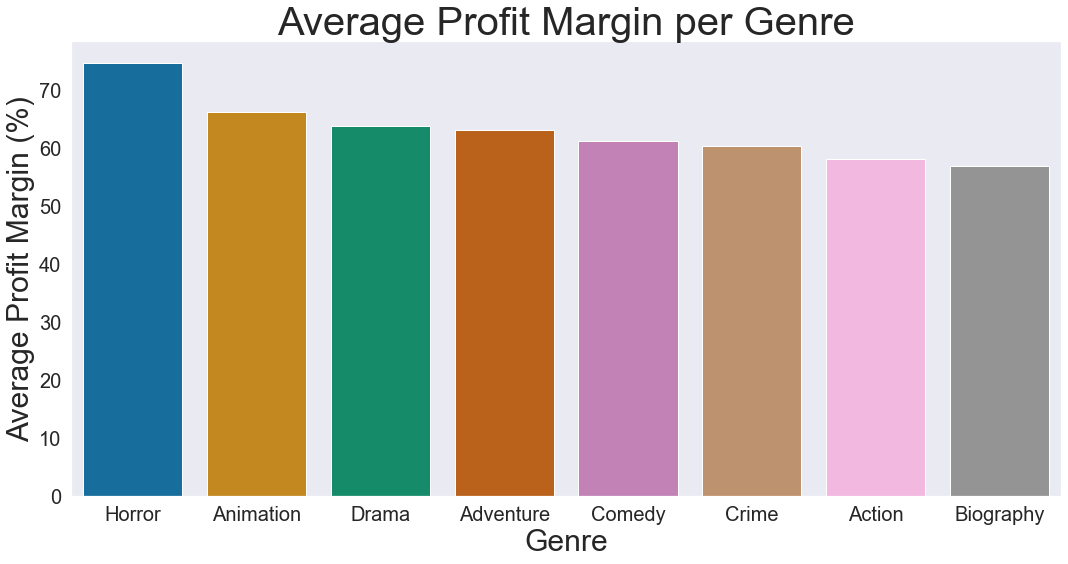

In [111]:
sns.set_theme(style="dark")
plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'genre', y='profit_margin', data=genre_avg_pm, palette = "colorblind")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax.set_title("Average Profit Margin per Genre",fontsize=40)
ax.set_xlabel("Genre",fontsize=30)
ax.set_ylabel("Average Profit Margin (%)",fontsize=30)
plt.tight_layout()
plt.savefig("AverageProfitMarginperGenre",bbox_inches='tight')

The bar chart shows which genres have the highest average profit margin. The top three genres are Horror, Animation and Drama. It should be noted, Horror has n 8.47% higher return than the next closest genre.

## Average Profit Margin per Rating

To create this visual we follow the following steps: <br>
    1. First call the merged dataframe.<br>
    2. Then pull out all relevant data for this visualization<br>
    3. Next calculate the average profit margin for each movie in each month and outputs a dataframe to investigate data<br>
    4. After, we round the profit margin for cleaner presentation <br>
    5.  Finally, create the Visualization

In [112]:
merged_df

,movie,rating,release_month,genre,production_budget,domestic_gross,worldwide_gross,profit_margin
3104,Mad Max,R,Mar,Action,200000.0,8750000.0,99750000.0,0.997995
569,Paranormal Activity,R,Sep,Horror,450000.0,107918810.0,194183034.0,0.997683
2339,The Gallows,R,Jul,Horror,100000.0,22764410.0,41656474.0,0.997599
374,The Blair Witch Project,R,Jul,Horror,600000.0,140539099.0,248300000.0,0.997584
606,Bambi,G,Aug,Animation,858000.0,102797000.0,268000000.0,0.996799
...,...,...,...,...,...,...,...,...
3665,Stoker,R,Mar,Drama,12000000.0,1703125.0,12034913.0,0.002901
1397,Absolute Power,R,Feb,Action,50000000.0,50068310.0,50068310.0,0.001364
1521,The Replacements,PG-13,Aug,Comedy,50000000.0,44737059.0,50054511.0,0.001089
3633,Nemesis,R,Jan,Action,2000000.0,2001124.0,2001124.0,0.000562


In [113]:
rating_df = merged_df.value_counts(["rating", "profit_margin"]).reset_index(name = "Number of Movies")

In [114]:
pm_per_rating_df = rating_df.groupby(["rating", "profit_margin"]).mean().reset_index().sort_values("profit_margin", ascending = False)

In [115]:
rating_avg_pm = pm_per_rating_df.groupby(["rating"]).mean().reset_index().sort_values("profit_margin", ascending = False)

In [116]:
rating_avg_pm['profit_margin'] = round(rating_avg_pm['profit_margin']*100, 2)

In [117]:
rating_avg_pm

,rating,profit_margin,Number of Movies
0,G,70.17,1.000000
1,PG,64.06,1.002101
3,R,60.89,1.000000
2,PG-13,60.34,1.000000


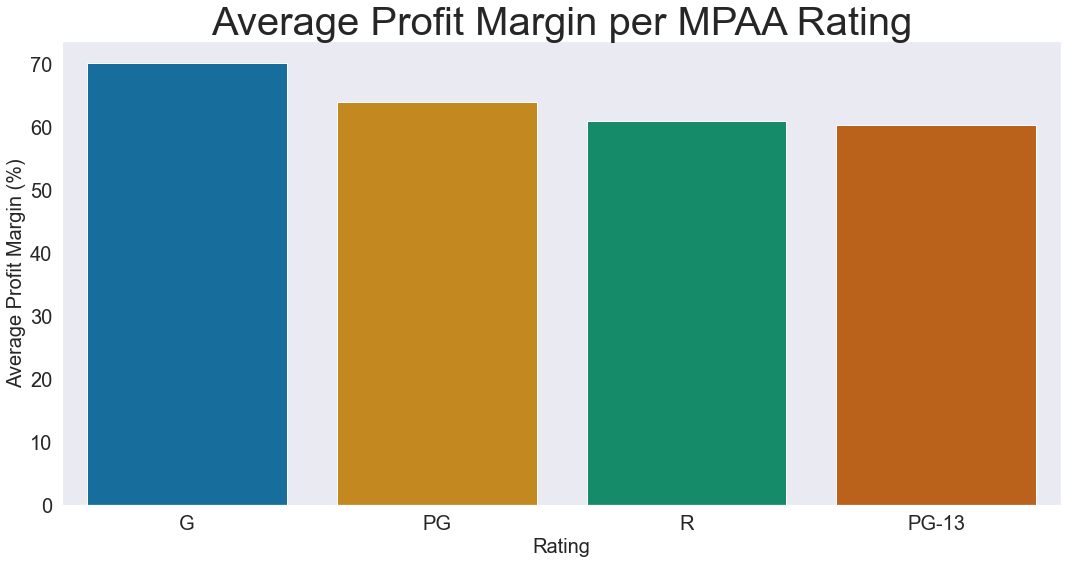

In [118]:
sns.set_theme(style="dark")
plt.figure(figsize = (15,8))

ax = sns.barplot(x = 'rating', y='profit_margin', data=rating_avg_pm, palette = "colorblind")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# ax.bar_label(ax.containers[0],fontsize=20)

ax.set_title("Average Profit Margin per MPAA Rating",fontsize=40)
ax.set_xlabel("Rating",fontsize=20)
ax.set_ylabel("Average Profit Margin (%)",fontsize=20)
plt.tight_layout()

plt.savefig("AverageProfitMarginperRating", bbox_inches='tight')

Here we are looking at the Average profit Margin per MPAA rating. The G rating has the highest rating of 70.17% followed by PG at 64.06%. These may be higher due to fammily films usually being rated G and PG. This means more people are seeing these movies because parents and whole families may attend these movies rather than indivuals or couples going to see a PG-13 or R rated movie.

### Average Profit Margin per Month
To create this visual we follow the following steps: <br>
    1. First call the merged dataframe.<br>
    2. Then pull out all relevant data for this visualization<br>
    3. Next calculate the average profit margin for each movie in each month and outputs a dataframe to investigate data<br>
    4. After, we round the profit margin for cleaner presentation <br>
    5.  Finally, create the Visualization

In [119]:
merged_df

,movie,rating,release_month,genre,production_budget,domestic_gross,worldwide_gross,profit_margin
3104,Mad Max,R,Mar,Action,200000.0,8750000.0,99750000.0,0.997995
569,Paranormal Activity,R,Sep,Horror,450000.0,107918810.0,194183034.0,0.997683
2339,The Gallows,R,Jul,Horror,100000.0,22764410.0,41656474.0,0.997599
374,The Blair Witch Project,R,Jul,Horror,600000.0,140539099.0,248300000.0,0.997584
606,Bambi,G,Aug,Animation,858000.0,102797000.0,268000000.0,0.996799
...,...,...,...,...,...,...,...,...
3665,Stoker,R,Mar,Drama,12000000.0,1703125.0,12034913.0,0.002901
1397,Absolute Power,R,Feb,Action,50000000.0,50068310.0,50068310.0,0.001364
1521,The Replacements,PG-13,Aug,Comedy,50000000.0,44737059.0,50054511.0,0.001089
3633,Nemesis,R,Jan,Action,2000000.0,2001124.0,2001124.0,0.000562


In [120]:
pm_months_genre_df =  merged_df.value_counts(["release_month", "profit_margin"]).reset_index(name = "Number of Movies")

In [121]:
month_avg_pm = pm_months_genre_df.groupby(["release_month"]).mean().reset_index().sort_values("profit_margin", ascending = False)

In [122]:
month_avg_pm['profit_margin'] = round(month_avg_pm['profit_margin']*100, 2)
month_avg_pm

,release_month,profit_margin,Number of Movies
6,Jun,65.05,1.0
5,Jul,64.35,1.0
2,Dec,63.80,1.0
8,May,62.78,1.0
9,Nov,62.34,1.0
3,Feb,62.13,1.0
10,Oct,61.21,1.0
4,Jan,60.56,1.0
1,Aug,59.35,1.0
7,Mar,58.82,1.0


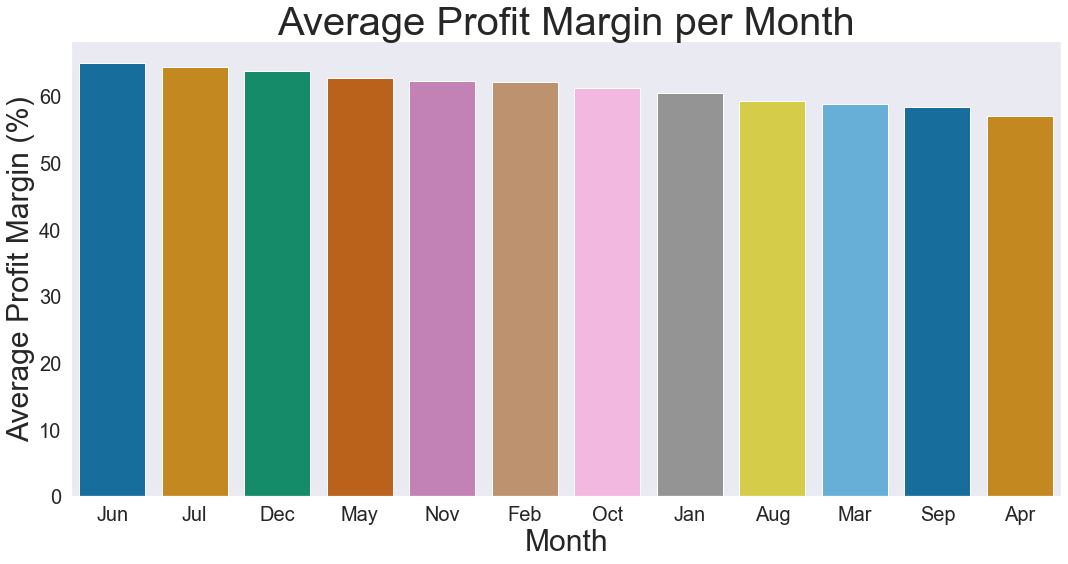

In [123]:
sns.set_theme(style="dark")
plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'release_month', y='profit_margin', data=month_avg_pm, palette = "colorblind")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# ax.bar_label(ax.containers[0],fontsize=15)

ax.set_title("Average Profit Margin per Month",fontsize=40)
ax.set_xlabel("Month",fontsize=30)
ax.set_ylabel("Average Profit Margin (%)",fontsize=30)
plt.tight_layout()
plt.savefig("AverageProfitMarginperMonth.png", bbox_inches='tight')

This bar chart shows which month is most profitable on average. The visualization shows June, July, December, May and November have the highest average profit margin.

### Average Profit Margin per Genre per Rating

To create this visual we follow the following steps: <br>
    1. First call the merged dataframe.<br>
    2. Then pull out all relevant data for this visualization<br>
    3. Next calculate the average profit margin for each movie in each month and outputs a dataframe to investigate data<br>
    4. After, we round the profit margin for cleaner presentation <br>
    5.  Finally, create the Visualization

In [124]:
merged_df

,movie,rating,release_month,genre,production_budget,domestic_gross,worldwide_gross,profit_margin
3104,Mad Max,R,Mar,Action,200000.0,8750000.0,99750000.0,0.997995
569,Paranormal Activity,R,Sep,Horror,450000.0,107918810.0,194183034.0,0.997683
2339,The Gallows,R,Jul,Horror,100000.0,22764410.0,41656474.0,0.997599
374,The Blair Witch Project,R,Jul,Horror,600000.0,140539099.0,248300000.0,0.997584
606,Bambi,G,Aug,Animation,858000.0,102797000.0,268000000.0,0.996799
...,...,...,...,...,...,...,...,...
3665,Stoker,R,Mar,Drama,12000000.0,1703125.0,12034913.0,0.002901
1397,Absolute Power,R,Feb,Action,50000000.0,50068310.0,50068310.0,0.001364
1521,The Replacements,PG-13,Aug,Comedy,50000000.0,44737059.0,50054511.0,0.001089
3633,Nemesis,R,Jan,Action,2000000.0,2001124.0,2001124.0,0.000562


In [125]:
ratings_df2 = merged_df.value_counts(["rating", "genre", "profit_margin"]).reset_index(name = "Number of Movies")
pm_by_rating_df = ratings_df2.groupby(["rating","genre"]).mean().reset_index().sort_values("profit_margin", ascending = False)
pm_by_rating_df['profit_margin'] = round(pm_by_rating_df['profit_margin']*100, 2)
pm_by_rating_df

,rating,genre,profit_margin,Number of Movies
0,G,Action,81.29,1.0
13,PG,Horror,78.66,1.0
5,G,Drama,77.79,1.0
24,R,Animation,77.54,1.0
21,PG-13,Horror,77.07,1.0
3,G,Biography,74.74,1.0
29,R,Horror,73.82,1.0
11,PG,Crime,71.97,1.0
2,G,Animation,69.50,1.0
1,G,Adventure,69.48,1.0


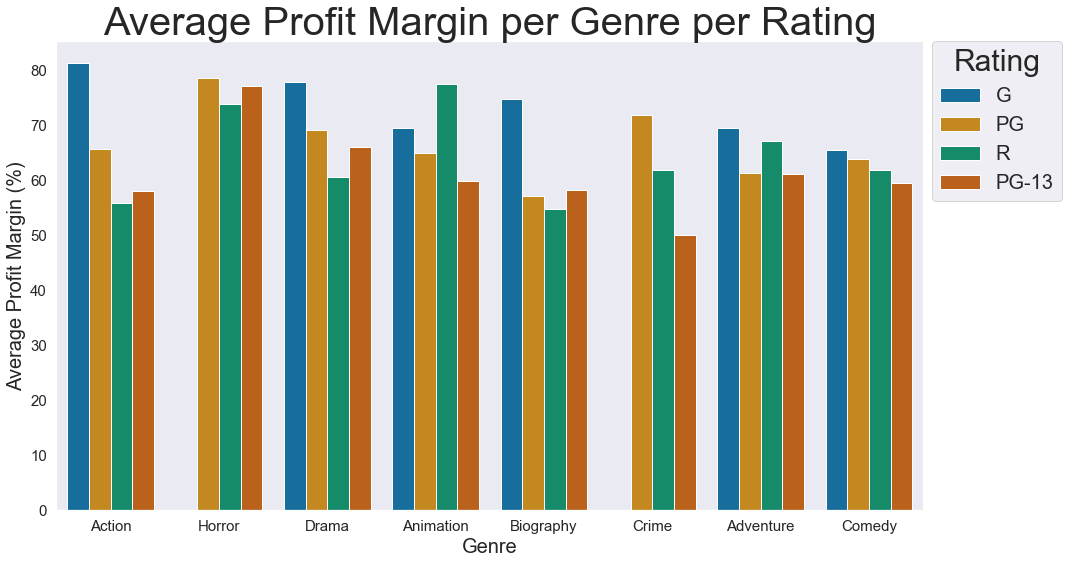

In [126]:
sns.set_theme(style="dark")
plt.figure(figsize = (15,8))

ax = sns.barplot(x = 'genre', y='profit_margin', 
               hue = 'rating', data=pm_by_rating_df, palette = "colorblind")

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# ax.bar_label(ax.containers[0],fontsize=10,rotation=45)
# ax.bar_label(ax.containers[1],fontsize=10,rotation=45)
# ax.bar_label(ax.containers[2],fontsize=10,rotation=45)
# ax.bar_label(ax.containers[3],fontsize=10,rotation=45)

plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0, title="Rating", fontsize=20, title_fontsize=30)

ax.set_title("Average Profit Margin per Genre per Rating",fontsize=40)
ax.set_xlabel("Genre",fontsize=20)
ax.set_ylabel("Average Profit Margin (%)",fontsize=20)
plt.tight_layout()
plt.savefig("AverageProfitMarginperGenreperRating", bbox_inches='tight')

This chart shows the average profit margin across the Genres and organized by ratings. THe G rating holds a consistantly higher profit margin across the genres, with the expecption of Horror and Crime. With those having no G rated films represented in the genres. It is curious to note R's unusally high represntation in the Animation genre. This would warrant further exploration into the data.

### Average Production Costper Genre

To create this visual we follow the following steps: <br>
    1. First call the merged dataframe.<br>
    2. Then pull out all relevant data for this visualization<br>
    3. Next calculate the average pproduction cost for each movie in each month and outputs a dataframe to investigate data<br>
    4. After, we round the production cost for cleaner presentation <br>
    5.  Finally, create the Visualization

In [127]:
genre_budget = copy_merged_df.value_counts(["genre", "production_budget"]).reset_index(name = "Number of Movies")
genre_budget_avg = genre_budget.groupby(["genre"]).mean().reset_index().sort_values("production_budget", ascending =True)
genre_budget_avg["production_budget"] = round(genre_budget_avg["production_budget"], 2)
genre_budget_avg

,genre,production_budget,Number of Movies
7,Horror,13068290.32,2.516129
5,Crime,26103070.72,2.034884
4,Comedy,27378703.59,4.835526
6,Drama,28459808.53,2.977941
3,Biography,29722031.25,2.812500
1,Adventure,62780573.17,2.073171
2,Animation,77061029.96,2.453333
0,Action,80204971.07,4.582857


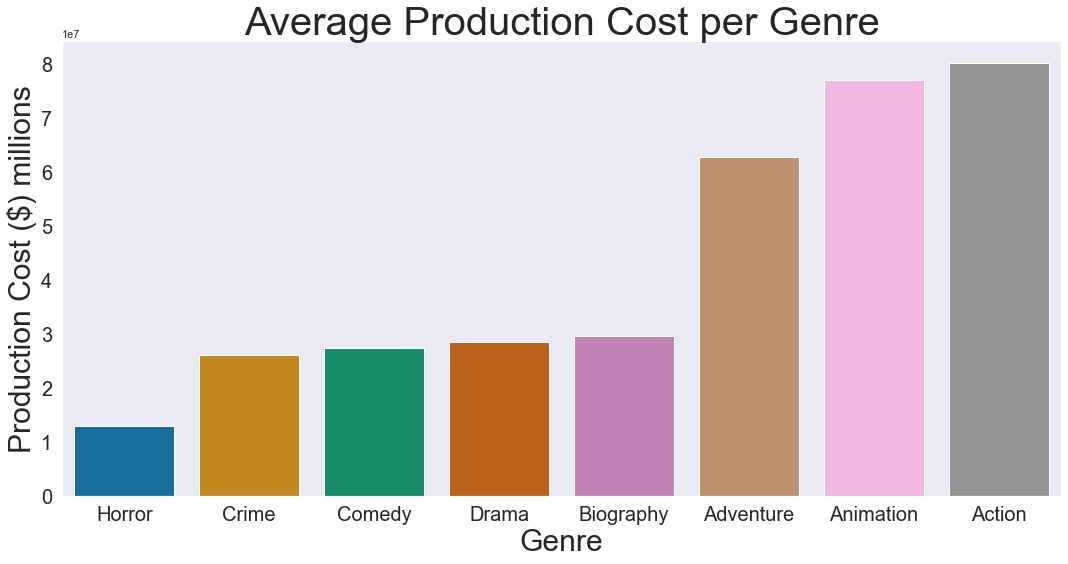

In [128]:

plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'genre', y="production_budget", data= genre_budget_avg, palette = "colorblind", ci = None)

# plt.xticks(rotation=45)
# plt.bar_label(ax.containers[0], fontsize=20)
ax.set_title("Average Production Cost per Genre",fontsize=40)
ax.set_xlabel("Genre",fontsize=30)
ax.set_ylabel("Production Cost ($) millions",fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize= 20)

plt.tight_layout()
plt.savefig("AverageProductionCostperGenre", bbox_inches='tight')

As we can see here the Horror genre has a much lower production cost than its counterparts. Drama has a middling production cost to boost its profitability. And while Animation does have a high production cost, as we have seen the animation profits are quite lucrative. 

### Average Production Cost per Rating

To create this visual we follow the following steps: <br>
    1. First call the merged dataframe.<br>
    2. Then pull out all relevant data for this visualization<br>
    3. Next calculate the average pproduction cost for each movie in each month and outputs a dataframe to investigate data<br>
    4. After, we round the production cost for cleaner presentation <br>
    5.  Finally, create the Visualization

In [129]:
rating_budget = copy_merged_df.value_counts(["rating", "production_budget"]).reset_index(name = "Number of Movies")
rating_budget_avg = rating_budget.groupby(["rating"]).mean().reset_index().sort_values("production_budget", ascending =True)
rating_budget_avg["production_budget"] = round(rating_budget_avg["production_budget"], 2)
rating_budget_avg

,rating,production_budget,Number of Movies
3,R,31202539.48,5.542986
0,G,47362986.55,1.482143
1,PG,58825920.86,3.431655
2,PG-13,71981757.44,5.241026


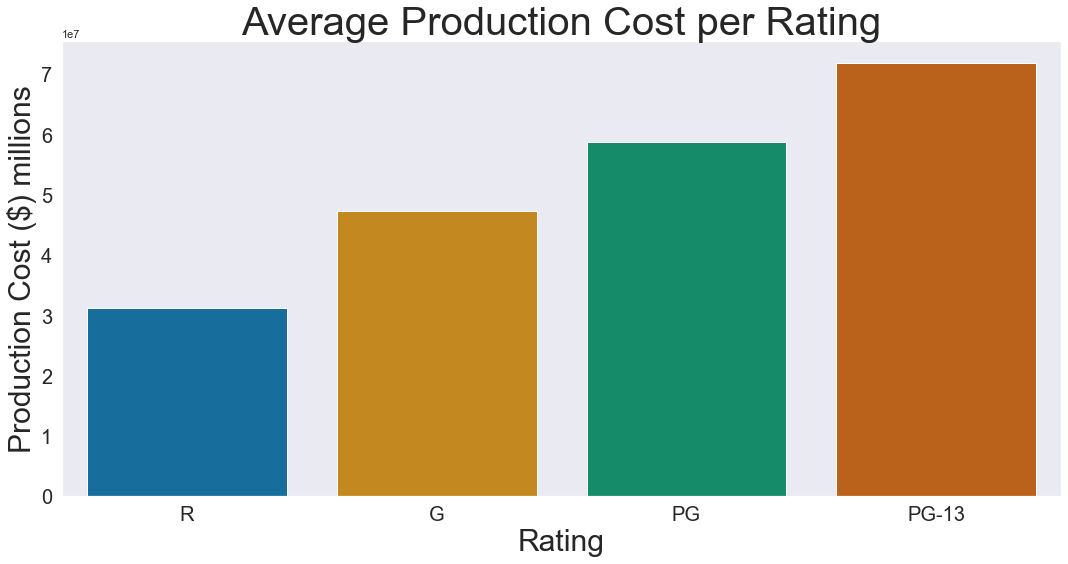

In [130]:
plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'rating', y="production_budget", data= rating_budget_avg, palette = "colorblind", ci = None)

# plt.bar_label(ax.containers[0], fontsize=20)
ax.set_title("Average Production Cost per Rating",fontsize=40)
ax.set_xlabel("Rating",fontsize=30)
ax.set_ylabel("Production Cost ($) millions",fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize= 20)

plt.tight_layout()
plt.savefig("AverageProductionCostperRating", bbox_inches='tight')

We see Horror and drama among other genres pull down the cost of making R rated movies. Keeping in mind Animated movie production costs we see a rise in the production costs for G and PG movies. 

### Ratings Avgerage Profit Margin per Month <br>
To create this visual we follow the following steps: <br>
    1. First call the merged dataframe.<br>
    2. Then pull out all relevant data for this visualization and remove extra data points<br>
    3. Next calculate the average profit margin for each movie in each month and outputs a dataframe to investigate data<br>
    4. After, we round the profit margin for cleaner presentation <br>
    5.  Finally, create the Visualization

In [131]:
copy_merged_df = merged_df.copy()

In [132]:
copy_merged_df

,movie,rating,release_month,genre,production_budget,domestic_gross,worldwide_gross,profit_margin
3104,Mad Max,R,Mar,Action,200000.0,8750000.0,99750000.0,0.997995
569,Paranormal Activity,R,Sep,Horror,450000.0,107918810.0,194183034.0,0.997683
2339,The Gallows,R,Jul,Horror,100000.0,22764410.0,41656474.0,0.997599
374,The Blair Witch Project,R,Jul,Horror,600000.0,140539099.0,248300000.0,0.997584
606,Bambi,G,Aug,Animation,858000.0,102797000.0,268000000.0,0.996799
...,...,...,...,...,...,...,...,...
3665,Stoker,R,Mar,Drama,12000000.0,1703125.0,12034913.0,0.002901
1397,Absolute Power,R,Feb,Action,50000000.0,50068310.0,50068310.0,0.001364
1521,The Replacements,PG-13,Aug,Comedy,50000000.0,44737059.0,50054511.0,0.001089
3633,Nemesis,R,Jan,Action,2000000.0,2001124.0,2001124.0,0.000562


In [133]:
release_months_df3 = copy_merged_df.value_counts(["release_month", "rating", "profit_margin"]).reset_index(name = "Number of Movies")
release_month_by_genre = release_months_df3.groupby(["release_month","rating"]).mean().reset_index().sort_values("profit_margin", ascending = False)
release_month_by_genre

,release_month,rating,profit_margin,Number of Movies
40,Oct,G,0.845289,1.0
16,Jan,G,0.826800,1.0
4,Aug,G,0.768091,1.0
12,Feb,G,0.755502,1.0
36,Nov,G,0.738499,1.0
32,May,G,0.714374,1.0
25,Jun,PG,0.699992,1.0
24,Jun,G,0.698816,1.0
9,Dec,PG,0.696963,1.0
23,Jul,R,0.679036,1.0


In [134]:
### A Special step here: in order to set the grapgh in chronological order, we definded the release month order
release_month_by_genre.release_month=pd.Categorical(release_month_by_genre.release_month,categories
                                                     =["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", 
                                                       "Aug", "Sep", "Oct", "Nov", "Dec"])
release_month_by_genre=release_month_by_genre.sort_values("release_month")
release_month_by_genre

,release_month,rating,profit_margin,Number of Movies
16,Jan,G,0.826800,1.0
19,Jan,R,0.563569,1.0
17,Jan,PG,0.646849,1.0
18,Jan,PG-13,0.621249,1.0
12,Feb,G,0.755502,1.0
15,Feb,R,0.611657,1.0
14,Feb,PG-13,0.601458,1.0
13,Feb,PG,0.674276,1.0
30,Mar,PG-13,0.553796,1.0
28,Mar,G,0.610665,1.0


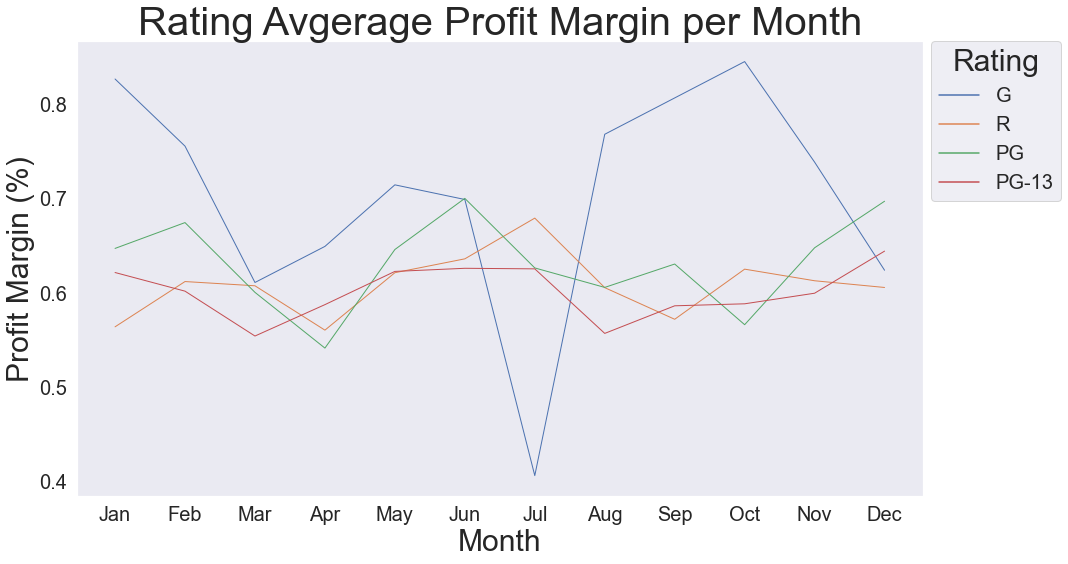

In [135]:
sns.set_theme(style="dark")
plt.figure(figsize = (15,8))
ax = sns.lineplot(
    data=release_month_by_genre,
    x="release_month", y="profit_margin", hue = "rating",
    estimator=None, lw=1,
)

plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0, title="Rating", fontsize=20, title_fontsize=30)

ax.set_title("Rating Avgerage Profit Margin per Month",fontsize=40)
ax.set_xlabel("Month",fontsize=30)
ax.set_ylabel("Profit Margin (%)",fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.savefig("RatingsAvgerageProfitMarginperMonth", bbox_inches='tight')

This graph is showing average profit margin for each rating each momth. G ratings have a high profit margin in January and August through October. This matches with the idea that kids are still on breaks from school and less competition from more adult rated movies. The sharp decline at the end of the year may be due to Oscar Season and studios more focused on serious, adult focused movies. PG Ratings mostly follow the same trends with less viariation in the data set. Rises in the data could be responsible to kids getting older and wanting to see movies focused on an older demographic. PG-13 Movies hold their profit margins consitantly through out the year. This could be due to targeting of a perfect mix of different demographics to maintain a reliable profit margin. R rated movies are very consistant as well. There are peaks in the data during the summer months where studio release their action blockblusters and in October where Horror movies, which tend to be R rated. Unsurprisingly, there are dips in profit margins for each rating at different points during the summer, when competition increases.

### Top Genre Avg Profit Margin per Month <br>
To create this visual we follow the following steps: <br>
    1. First call the merged dataframe.<br>
    2. Then pull out all relevant data for this visualization and remove extra data points<br>
    3. Next calculate the average profit margin for each movie in each month and outputs a dataframe to investigate data<br>
    4. After, we round the profit margin for cleaner presentation <br>
    5.  Finally, create the Visualization

In [136]:
copy_merged_df

,movie,rating,release_month,genre,production_budget,domestic_gross,worldwide_gross,profit_margin
3104,Mad Max,R,Mar,Action,200000.0,8750000.0,99750000.0,0.997995
569,Paranormal Activity,R,Sep,Horror,450000.0,107918810.0,194183034.0,0.997683
2339,The Gallows,R,Jul,Horror,100000.0,22764410.0,41656474.0,0.997599
374,The Blair Witch Project,R,Jul,Horror,600000.0,140539099.0,248300000.0,0.997584
606,Bambi,G,Aug,Animation,858000.0,102797000.0,268000000.0,0.996799
...,...,...,...,...,...,...,...,...
3665,Stoker,R,Mar,Drama,12000000.0,1703125.0,12034913.0,0.002901
1397,Absolute Power,R,Feb,Action,50000000.0,50068310.0,50068310.0,0.001364
1521,The Replacements,PG-13,Aug,Comedy,50000000.0,44737059.0,50054511.0,0.001089
3633,Nemesis,R,Jan,Action,2000000.0,2001124.0,2001124.0,0.000562


In [137]:
release_months_df2 = copy_merged_df.value_counts(["release_month", "genre", "profit_margin"]).reset_index(name = "Number of Movies")
release_month_by_genre = release_months_df2.groupby(["release_month","genre"]).mean().reset_index().sort_values("profit_margin", ascending = False)
release_month_by_genre

,release_month,genre,profit_margin,Number of Movies
39,Jan,Horror,0.844669,1.0
71,May,Horror,0.811552,1.0
31,Feb,Horror,0.794811,1.0
63,Mar,Horror,0.756586,1.0
95,Sep,Horror,0.756095,1.0
...,...,...,...,...
67,May,Biography,0.495697,1.0
5,Apr,Crime,0.494834,1.0
3,Apr,Biography,0.413347,1.0
37,Jan,Crime,0.383050,1.0


In [138]:
release_month_by_genre2 = release_month_by_genre[release_month_by_genre.genre != "Biography"]

In [139]:
release_month_by_genre3 = release_month_by_genre2[release_month_by_genre2.genre != "Adventure"]

In [140]:
release_month_by_genre4 = release_month_by_genre3[release_month_by_genre2.genre != "Crime"]

C:\Users\david\AppData\Local\Temp/ipykernel_17016/1020678697.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  release_month_by_genre4 = release_month_by_genre3[release_month_by_genre2.genre != "Crime"]


In [141]:
release_month_by_genre5 = release_month_by_genre4[release_month_by_genre2.genre != "Action"]

C:\Users\david\AppData\Local\Temp/ipykernel_17016/269171665.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  release_month_by_genre5 = release_month_by_genre4[release_month_by_genre2.genre != "Action"]


In [142]:
release_month_by_genre6 = release_month_by_genre5[release_month_by_genre2.genre != "Comedy"]

C:\Users\david\AppData\Local\Temp/ipykernel_17016/2277110321.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  release_month_by_genre6 = release_month_by_genre5[release_month_by_genre2.genre != "Comedy"]


In [143]:
release_month_by_genre6.sort_values("release_month")

,release_month,genre,profit_margin,Number of Movies
7,Apr,Horror,0.735687,1.0
6,Apr,Drama,0.547494,1.0
2,Apr,Animation,0.694375,1.0
14,Aug,Drama,0.606097,1.0
10,Aug,Animation,0.606632,1.0
15,Aug,Horror,0.734922,1.0
18,Dec,Animation,0.686617,1.0
23,Dec,Horror,0.675718,1.0
22,Dec,Drama,0.681930,1.0
31,Feb,Horror,0.794811,1.0


### A Special step here: in order to set the grapgh in chronological order, we definded the release month order

In [144]:
release_month_by_genre6.release_month=pd.Categorical(release_month_by_genre6.release_month,categories
                                                     =["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", 
                                                       "Aug", "Sep", "Oct", "Nov", "Dec"])
release_month_by_genre6=release_month_by_genre6.sort_values("release_month")

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [145]:
release_month_by_genre6

,release_month,genre,profit_margin,Number of Movies
39,Jan,Horror,0.844669,1.0
38,Jan,Drama,0.682517,1.0
34,Jan,Animation,0.704672,1.0
31,Feb,Horror,0.794811,1.0
30,Feb,Drama,0.681731,1.0
26,Feb,Animation,0.716705,1.0
62,Mar,Drama,0.611401,1.0
63,Mar,Horror,0.756586,1.0
58,Mar,Animation,0.621330,1.0
7,Apr,Horror,0.735687,1.0


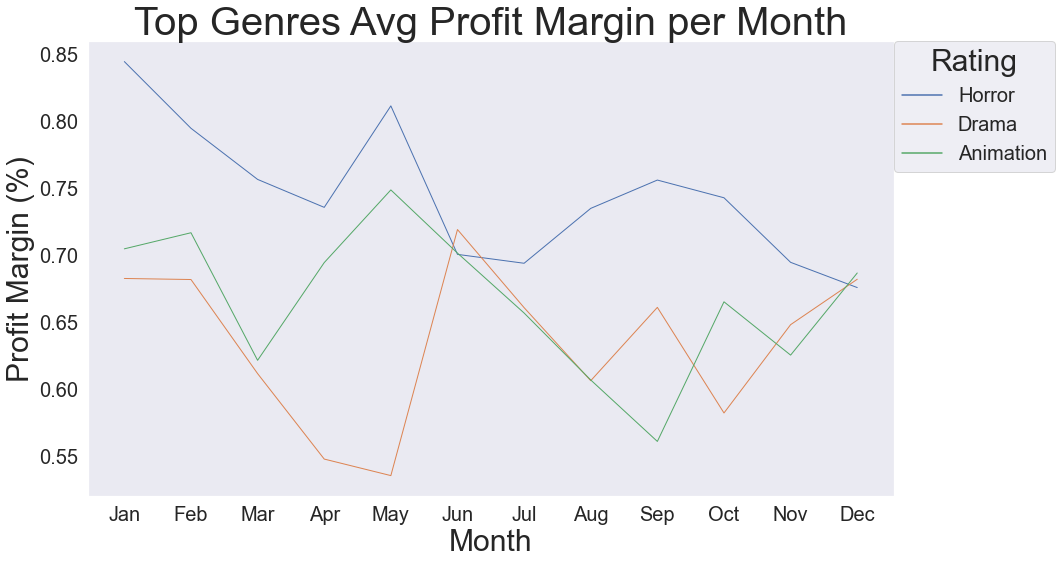

In [146]:
sns.set_theme(style="dark")
plt.figure(figsize = (15,8))
ax = sns.lineplot(
    data=release_month_by_genre6,
    x="release_month", y="profit_margin", hue = "genre",
    estimator=None, lw=1,
)

ax.set_title("Top Genres Avg Profit Margin per Month",fontsize=40)
ax.set_xlabel("Month",fontsize=30)
ax.set_ylabel("Profit Margin (%)",fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(bbox_to_anchor=(1.2, 1),
           borderaxespad=0, title="Rating", fontsize=20, title_fontsize=30)

plt.tight_layout()
plt.savefig("TopGenreAvgProfitMarginperMonth", bbox_inches='tight')

This line graph shows the highest average profit margin each month for the top three genres, Horror, Animation and Drama.The poits of interest here include peaks for Horror in Jan, May, September. This could be due to lower competition during these times. The rise in profit margins for Drama in September and at the end of the year may conincide with "Oscar Season" where studios will release their Oscar competitors. This would also explain the drop at the beginning of year; Oscar competitors may be forgotton by the time Oscar voting comes around. The peaks and valleys of Animation follow the school breaks with peaks In February May and December. The lower profit margins for all genres in the summer may do to higher competition with the box office revenues being more split between all of the genres.